In [1]:
from typing import Any, Callable, Dict, Optional, Tuple
from typing import Union
from cvxopt import matrix, spmatrix
from cvxopt.solvers import options, qp
from numpy import array, ndarray
from numpy import hstack, sqrt, vstack, zeros, inf,  ones
from numpy.linalg import cholesky
from numpy.linalg import LinAlgError, norm
from scipy.sparse import csc_matrix
from warnings import warn
from ecos import solve
from scipy import sparse
from scipy.sparse import csc_matrix
from gurobipy import GRB, Model
from osqp import OSQP
from quadprog import solve_qp
from scs import solve
import numpy as np
import cvxpy as cp
import osqp
import time 
import matplotlib.pyplot as plt

### cvxopt

In [2]:
CvxoptReadyMatrix = Union[ndarray, matrix, spmatrix]

options["show_progress"] = False  # disable cvxopt output


def cvxopt_matrix(M: CvxoptReadyMatrix) -> matrix:
    if isinstance(M, ndarray):
        return matrix(M)
    if isinstance(M, (spmatrix, matrix)):
        return M
    coo = M.tocoo()
    return spmatrix(
        coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size=M.shape
    )


def cvxopt_solve_qp(
    P: CvxoptReadyMatrix,
    q: CvxoptReadyMatrix,
    G: Optional[CvxoptReadyMatrix] = None,
    h: Optional[CvxoptReadyMatrix] = None,
    A: Optional[CvxoptReadyMatrix] = None,
    b: Optional[CvxoptReadyMatrix] = None,
    solver: str = None,
    initvals: Optional[ndarray] = None,
    verbose: bool = False,
) -> Optional[ndarray]:
   
    options["show_progress"] = verbose
    args = [cvxopt_matrix(P), cvxopt_matrix(q)]
    kwargs = {"G": None, "h": None, "A": None, "b": None}
    if G is not None and h is not None:
        kwargs["G"] = cvxopt_matrix(G)
        kwargs["h"] = cvxopt_matrix(h)
    if A is not None and b is not None:
        kwargs["A"] = cvxopt_matrix(A)
        kwargs["b"] = cvxopt_matrix(b)
    sol = qp(*args, solver=solver, initvals=initvals, **kwargs)
    if "optimal" not in sol["status"]:
        return None
    return array(sol["x"]).reshape((q.shape[0],))
  

### cvxpy

In [3]:
def cvxpy_solve_qp(n,P, q, G, h, A, b, solver: str = None,
                    initvals: Optional[ndarray] = None,
                   ) -> Optional[ndarray]:
    
    # Define and solve the CVXPY problem.
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),[G @ x <= h,A @ x == b])
    prob.solve()
 #   return (prob.solve())
  #  return array(x).reshape((q.shape[0],))
  #  print(x.value)


### ecos

In [4]:
def convert_to_socp( P, q, G, h)-> Tuple[ndarray, ndarray, ndarray, Dict[str, Any]]:

    n = P.shape[1]  # dimension of QP variable
    c_socp = hstack([zeros(n), 1])  # new SOCP variable stacked as [x, t]
    try:
        L = cholesky(P)
    except LinAlgError as e:
        error = str(e)
        if "not positive definite" in error:
            raise ValueError("matrix P is not positive definite") from e
        raise e  # other linear algebraic error

    scale = 1.0 / sqrt(2)
    G_quad = vstack(
        [
            scale * hstack([q, -1.0]),
            hstack([-L.T, zeros((L.shape[0], 1))]),
            scale * hstack([-q, +1.0]),
        ]
    )
    h_quad = hstack([scale, zeros(L.shape[0]), scale])

    dims: Dict[str, Any] = {"q": [L.shape[0] + 2]}
    G_socp = vstack([hstack([G, zeros((G.shape[0], 1))]), G_quad])
    h_socp = hstack([h, h_quad])
    dims["l"] = G.shape[0]

    G_socp = csc_matrix(G_socp)
    return c_socp, G_socp, h_socp, dims


__exit_flag_meaning__ = {
    0: "OPTIMAL",
    1: "PRIMAL INFEASIBLE",
    2: "DUAL INFEASIBLE",
    -1: "MAXIT REACHED",
}


def ecos_solve_qp(
    P: ndarray,
    q: ndarray,
    G: Optional[ndarray] = None,
    h: Optional[ndarray] = None,
    A: Optional[ndarray] = None,
    b: Optional[ndarray] = None,
    initvals: Optional[ndarray] = None,
    verbose: bool = False,
) -> Optional[ndarray]:
    from ecos import solve
    if initvals is not None:
        warn("note that warm-start values ignored by this wrapper")
    c_socp, G_socp, h_socp, dims = convert_to_socp(P, q, G, h)
    if A is not None:
        A_socp = sparse.hstack(
            [A, sparse.csc_matrix((A.shape[0], 1))], format="csc"
        )
        solution = solve(
            c_socp, G_socp, h_socp, dims, A_socp, b, verbose=verbose
        )
    else:
        solution = solve(c_socp, G_socp, h_socp, dims, verbose=verbose)
    flag = solution["info"]["exitFlag"]
    if flag != 0:
        warn(f"ECOS returned exit flag {flag} ({__exit_flag_meaning__[flag]})")
        return None
    return solution["x"][:-1]


### gurobi

In [5]:
def gurobi_solve_qp( P, q, G, h, A, b, 
                    initvals: Optional[ndarray] = None, verbose: bool = False,) -> Optional[ndarray]:
   
    model = Model()
    
    if not verbose:  # optionally turn off solver output
        model.setParam("OutputFlag", 0)
            
    num_vars = P.shape[0]
    x = model.addMVar( num_vars, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS )
    model.addMConstr(A, x, GRB.EQUAL, b)
    model.addMConstr(G, x, GRB.LESS_EQUAL, h)
    objective = 0.5 * (x @ P @ x) + q @ x
    model.setObjective(objective, sense=GRB.MINIMIZE)
    model.optimize()
    status = model.status
    if status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        return None
    return array(x.X)



def gurobi_solve_qp( P, q, G, h, A, b, 
                    initvals: Optional[ndarray] = None, verbose: bool = False,) -> Optional[ndarray]:
   
    model = Model()
    
    if not verbose:  # optionally turn off solver output
        model.setParam("OutputFlag", 0)
            
    num_vars = P.shape[0]
    x = model.addMVar( num_vars, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS )
    model.addMConstr(A, x, GRB.EQUAL, b)
    model.addMConstr(G, x, GRB.LESS_EQUAL, h)
    objective = 0.5 * (x @ P @ x) + q @ x
    model.setObjective(objective, sense=GRB.MINIMIZE)
    model.optimize()
    status = model.status
    if status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        return None
    return array(x.X)

### osqp

In [6]:
DenseOrCSCMatrix = Union[ndarray, csc_matrix]

def osqp_solve_qp( P, q, G, h, A, b,initvals: Optional[DenseOrCSCMatrix] = None, 
                  verbose: bool = False, eps_abs: float = 1e-4, eps_rel: float = 1e-4, 
                  polish: bool = True, **kwargs) -> Optional[ndarray]:
   
    if isinstance(P, ndarray):
        P = sparse.csc_matrix(P)
    solver = OSQP()
    kwargs = { "eps_abs": eps_abs, "eps_rel": eps_rel, "polish": polish, "verbose": verbose,}
    
    if isinstance(A, ndarray):
            A = sparse.csc_matrix(A)
    l_inf = -inf * ones(len(h))
    qp_A = sparse.vstack([G, A], format="csc")
    qp_l = hstack([l_inf, b])
    qp_u = hstack([h, b])
    solver.setup(P=P, q=q, A=qp_A, l=qp_l, u=qp_u, **kwargs)
    
    
    if initvals is not None:
        solver.warm_start(x=initvals)
    res = solver.solve()
    if hasattr(solver, "constant"):
        success_status = solver.constant("OSQP_SOLVED")
    else:  # more recent versions of OSQP
        success_status = osqp.constant("OSQP_SOLVED")
    if res.info.status_val != success_status:
        warn(f"OSQP exited with status '{res.info.status}'")
        return None
    return res.x

### quadprog

In [7]:
def quadprog_solve_qp( P, q, G, h, A, b, initvals: ndarray = None, 
                      verbose: bool = False, **kwargs,) -> Optional[ndarray]:  
    qp_G = P
    qp_a = -q
    qp_C: Optional[ndarray] = None
    qp_b: Optional[ndarray] = None
    qp_C = -vstack([A, G]).T
    qp_b = -hstack([b, h])
    meq = A.shape[0]

    try:
        return solve_qp(qp_G, qp_a, qp_C, qp_b, meq, **kwargs)[0]
    except ValueError as e:
        error = str(e)
        if "matrix G is not positive definite" in error:
            # quadprog writes G the cost matrix that we write P in this package
            raise ValueError("matrix P is not positive definite") from e
        if "no solution" in error:
            return None
        warn(f"quadprog raised a ValueError: {e}")
        return None

### scs

In [8]:
DenseOrCSCMatrix = Union[ndarray, csc_matrix]

def scs_solve_qp( P, q, G, h, A, b, initvals: Optional[ndarray] = None, 
                 eps_abs: float = 1e-7, eps_rel: float = 1e-7, verbose: 
                 bool = False, **kwargs,) -> Optional[ndarray]:
    from scs import solve
    if isinstance(P, ndarray):
        P = sparse.csc_matrix(P)
    if isinstance(G, ndarray):
        G = sparse.csc_matrix(G)
    if isinstance(A, ndarray):
        A = sparse.csc_matrix(A)
    kwargs.update({ "eps_abs": eps_abs,"eps_rel": eps_rel,"verbose": verbose,})
    
    data = {"P": P, "c": q}
    cone = {}
    if initvals is not None:
        data["x"] = initvals
    
    data["A"] = sparse.vstack([A, G], format="csc")
    data["b"] = hstack([b, h])
    cone["z"] = b.shape[0]  # zero cone
    cone["l"] = h.shape[0]  # positive orthant
   
    solution = solve(data, cone, **kwargs)
    status_val = solution["info"]["status_val"]

    return solution["x"]

### Experiments

In [9]:
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]


In [10]:
m = 10
n = 10
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)



#cvxpy_solve_qp(n,P,q, G,h,A,b)
#ecos_solve_qp( P,q, G,h,A,b)
gurobi_solve_qp( P,q, G,h,A,b)
#osqp_solve_qp( P,q, G,h,A,b)
#quadprog_solve_qp( P,q, G,h,A,b)
#scs_solve_qp( P,q, G,h,A,b)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-05


In [11]:
m = 10
n = 10
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start0 = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end0 = time.perf_counter()
t1.append(end0-start0)

start1 = time.perf_counter()
cvxpy_solve_qp(n,P,q, G,h,A,b)
end1 = time.perf_counter()
t2.append(end1-start1)

start2 = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end2 = time.perf_counter()
t3.append(end2-start2)

start3 = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end3 = time.perf_counter()
t4.append(end3-start3)

start4 = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end4 = time.perf_counter()
t5.append(end4-start4)

start5 = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end5 = time.perf_counter()
t6.append(end5-start5)

start6 = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end6 = time.perf_counter()
t7.append(end6-start6)



C:\Users\whgui\AppData\Local\Temp\ipykernel_5452\313039575.py:65: UserWarning: ECOS returned exit flag 1 (PRIMAL INFEASIBLE)
  warn(f"ECOS returned exit flag {flag} ({__exit_flag_meaning__[flag]})")
C:\Users\whgui\AppData\Local\Temp\ipykernel_5452\3373300652.py:29: UserWarning: OSQP exited with status 'primal infeasible'
  warn(f"OSQP exited with status '{res.info.status}'")


In [12]:
m = 10
n = 40
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)

start = time.perf_counter()
cvxpy_solve_qp(n,P,q, G,h,A,b)
end = time.perf_counter()
t2.append(end-start)

start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [13]:
m = 10
n = 70
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)

start = time.perf_counter()
cvxpy_solve_qp(n,P,q, G,h,A,b)
end = time.perf_counter()
t2.append(end-start)

start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [14]:
m = 10
n = 100
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)

start = time.perf_counter()
cvxpy_solve_qp(n,P,q, G,h,A,b)
end = time.perf_counter()
t2.append(end-start)

start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [15]:
m = 15
n = 400
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)


start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [16]:
m = 10
n = 700
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [17]:
m = 10
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [18]:
m = 10
n = 1300
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [19]:
m = 10
n = 1500
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



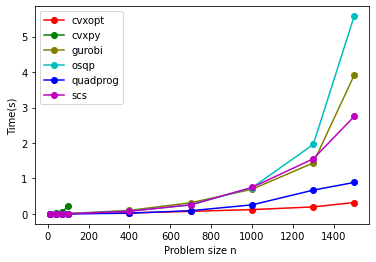

In [20]:
x = [10,40,70,100,400,700,1000,1300,1500]
y = [10,40,70,100]

plt.plot(x,t1,'o-',color = 'r',label="cvxopt")
plt.plot(y,t2,'o-',color = 'g',label="cvxpy")
#plt.plot(x,t3,'o-',color = 'orange',label="ecos")
plt.plot(x,t4,'o-',color = 'olive',label="gurobi")
plt.plot(x,t5,'o-',color = 'c',label="osqp")
plt.plot(x,t6,'o-',color = 'b',label="quadprog")
plt.plot(x,t7,'o-',color = 'm',label="scs")

plt.xlabel("Problem size n ")
plt.ylabel("Time(s)")
plt.legend(loc = "best")
plt.show()


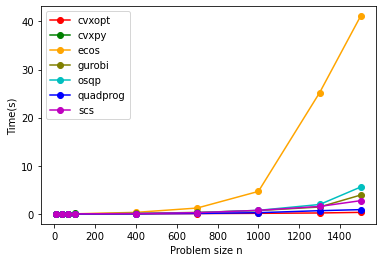

In [21]:
x = [10,40,70,100,400,700,1000,1300,1500]
y = [10,40,70,100]

plt.plot(x,t1,'o-',color = 'r',label="cvxopt")
plt.plot(y,t2,'o-',color = 'g',label="cvxpy")
plt.plot(x,t3,'o-',color = 'orange',label="ecos")
plt.plot(x,t4,'o-',color = 'olive',label="gurobi")
plt.plot(x,t5,'o-',color = 'c',label="osqp")
plt.plot(x,t6,'o-',color = 'b',label="quadprog")
plt.plot(x,t7,'o-',color = 'm',label="scs")

plt.xlabel("Problem size n ")
plt.ylabel("Time(s)")
plt.legend(loc = "best")
plt.show()


In [22]:
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]


In [23]:
m = 10
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [24]:
m = 40
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [25]:
m = 70
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



In [26]:
m = 100
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)



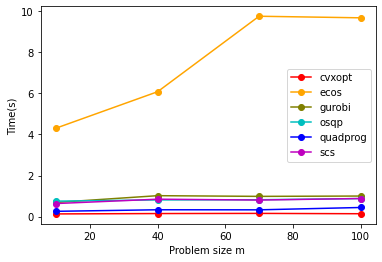

In [27]:
x = [10,40,70,100]
y = [10,40,70,100]

plt.plot(x,t1,'o-',color = 'r',label="cvxopt")
#plt.plot(y,t2,'o-',color = 'g',label="cvxpy")
plt.plot(x,t3,'o-',color = 'orange',label="ecos")
plt.plot(x,t4,'o-',color = 'olive',label="gurobi")
plt.plot(x,t5,'o-',color = 'c',label="osqp")
plt.plot(x,t6,'o-',color = 'b',label="quadprog")
plt.plot(x,t7,'o-',color = 'm',label="scs")

plt.xlabel("Problem size m ")
plt.ylabel("Time(s)")
plt.legend(loc = "best")
plt.show()


In [28]:
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]

In [29]:
m = 10
n = 1000
p = 10
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)


In [30]:
m = 10
n = 1000
p = 40
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)


In [31]:
m = 10
n = 1000
p = 70
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)


In [32]:
m = 10
n = 1000
p = 100
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

start = time.perf_counter()
cvxopt_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t1.append(end-start)



start = time.perf_counter()
ecos_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t3.append(end-start)

start = time.perf_counter()
gurobi_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t4.append(end-start)

start = time.perf_counter()
osqp_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t5.append(end-start)

start = time.perf_counter()
quadprog_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t6.append(end-start)

start = time.perf_counter()
scs_solve_qp( P,q, G,h,A,b)
end = time.perf_counter()
t7.append(end-start)


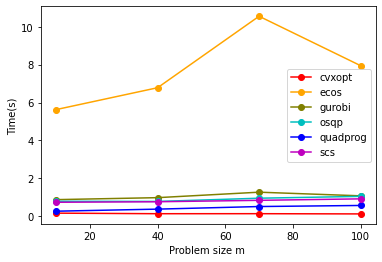

In [33]:
x = [10,40,70,100]
y = [10,40,70,100]

plt.plot(x,t1,'o-',color = 'r',label="cvxopt")
#plt.plot(y,t2,'o-',color = 'g',label="cvxpy")
plt.plot(x,t3,'o-',color = 'orange',label="ecos")
plt.plot(x,t4,'o-',color = 'olive',label="gurobi")
plt.plot(x,t5,'o-',color = 'c',label="osqp")
plt.plot(x,t6,'o-',color = 'b',label="quadprog")
plt.plot(x,t7,'o-',color = 'm',label="scs")

plt.xlabel("Problem size m ")
plt.ylabel("Time(s)")
plt.legend(loc = "best")
plt.show()
